Imports & Setup

In [24]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import matplotlib as mpl 
from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# --- Configuration ---
# Set input file path and random seed for reproducibility
INPUT_FILE = "sensed_data.csv"
SEED = 42
np.random.seed(SEED)

# --- NLTK Setup ---
# Download necessary NLTK resources
def download_nltk_resources():
    resources = ['punkt', 'wordnet', 'stopwords', 'omw-1.4']
    for res in resources:
        try:
            nltk.data.find(f'corpora/{res}')
        except LookupError:
            nltk.download(res, quiet=True)

download_nltk_resources()

# Initialize Lemmatizer and define English stopwords set
LEMMATIZER = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))

print("Setup Complete. Libraries Loaded.")

Setup Complete. Libraries Loaded.


Pre_processing

In [31]:
def clean_text(text):
    """
    Applies cleaning logic: Lowercasing, remove noise, Lemmatization.
    """
    if not isinstance(text, str): return ""
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Keep only alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenization & Lemmatization
    words = text.split()

    # 4. Processing: Remove stopwords and apply lemmatization
    processed_words = [
        LEMMATIZER.lemmatize(word, pos='v') 
        for word in words 
        if word not in STOP_WORDS and len(word) > 2 
    ]
    return " ".join(processed_words)

def run_preprocessing(input_path):
    print(" Starting Pre-processing ")
    df = pd.read_csv(input_path)
    print(f"Loaded {len(df)} rows.")
    
    # Drop missing
    df = df.dropna(subset=['BodyText', 'Label'])
    
    # Drop duplicates
    initial_len = len(df)
    df = df.drop_duplicates(subset=['BodyText'])
    if len(df) < initial_len:
        print(f"Removed {initial_len - len(df)} duplicates.")

    # Apply cleaning
    df['CleanedBody'] = df['BodyText'].apply(clean_text)
    df['CleanedTitle'] = df['Title'].apply(clean_text)
    
    print("Pre-processing finished.")
    return df

df_preprocessed = run_preprocessing(INPUT_FILE)
df_preprocessed.groupby('Label').head(3)

 Starting Pre-processing 
Loaded 19806 rows.
Pre-processing finished.


,Label,Title,Byline,URL,BodyText,CleanedBody,CleanedTitle
0,culture,Walls that talk: how to buy real art in lockdo...,Elissa Blake,https://www.theguardian.com/artanddesign/2021/...,You’ve been locked down and staring at the wal...,youve lock star wall months time change scene ...,wall talk buy real art lockdown budget find cu...
1,culture,"Iridescent: Gerwyn Davies’ colourful, camp cos...",Steve Dow,https://www.theguardian.com/artanddesign/2021/...,"Minnie Macgregor’s deadpan portrait, taken cir...",minnie macgregors deadpan portrait take circa ...,iridescent gerwyn davies colourful camp costum...
2,culture,Melbourne’s augmented reality: is public art t...,Tim Byrne,https://www.theguardian.com/artanddesign/2021/...,Paris has its Latin Quarter and Barcelona its ...,paris latin quarter barcelona gothic quarter e...,melbournes augment reality public art remedy c...
4859,news,Commonwealth Bank profit jumps to $5.15bn amid...,Jonathan Barrett,https://www.theguardian.com/australia-news/202...,Commonwealth Bank has reported a record half-y...,commonwealth bank report record halfyear cash ...,commonwealth bank profit jump amid rise intere...
4860,news,Greyhound racing injuries and deaths surge des...,Tamsin Rose,https://www.theguardian.com/australia-news/202...,The number of greyhounds injured or dying on N...,number greyhounds injure die new south wales r...,greyhound race injuries deaths surge despite n...
4861,news,"All Australians ‘hold you in our hearts’, Anth...",Martin Farrer,https://www.theguardian.com/australia-news/202...,Anthony Albanese has told Australian Jews that...,anthony albanese tell australian jews governme...,australians hold hearts anthony albanese tell ...
9859,opinion,"As interest rates fall, could Australia be fac...",James Graham for the Conversation,https://www.theguardian.com/australia-news/202...,"With the Reserve Bank easing monetary policy, ...",reserve bank ease monetary policy interest rat...,interest rat fall could australia face another...
9860,opinion,Australian cities are desperate for the ‘missi...,Peter Mares,https://www.theguardian.com/australia-news/com...,The Business Council of Australia wants local ...,business council australia want local governme...,australian cities desperate miss middle house ...
9861,opinion,The Children’s Booker prize will tell kids tha...,Frank Cottrell-Boyce,https://www.theguardian.com/books/2025/oct/24/...,"At the end of the movie Ratatouille, the food ...",end movie ratatouille food reviewer anton ego ...,childrens booker prize tell kid matter
14856,sport,Take the strain! Tug of War World Championship...,Tom Jenkins,https://www.theguardian.com/artanddesign/2025/...,“Pick up the rope! Take the strain! Steady! Pu...,pick rope take strain steady pull referee bark...,take strain tug war world championships pictur...


Segmentation

In [32]:
def run_segmentation(df):
    
    # Fail Fast
    required = ['CleanedTitle', 'CleanedBody', 'Label']
    for col in required:
        assert col in df.columns, f"Missing {col}"

    df['CleanedTitle'] = df['CleanedTitle'].fillna("")
    df['CleanedBody'] = df['CleanedBody'].fillna("")

    # Create the segment
    df['Segmented_Content'] = df['CleanedTitle'] + " " + df['CleanedBody']
    
    # Filter empty results
    df = df[df['Segmented_Content'].str.strip().astype(bool)]
    
    # Keep only relevant columns
    output_df = df[['Label', 'Segmented_Content']]
    
    print(f"Segmentation finished. Current shape: {output_df.shape}")
    return output_df

df_segmented = run_segmentation(df_preprocessed)
df_segmented.groupby('Label').head(3)

Segmentation finished. Current shape: (19806, 2)


,Label,Segmented_Content
0,culture,wall talk buy real art lockdown budget find cu...
1,culture,iridescent gerwyn davies colourful camp costum...
2,culture,melbournes augment reality public art remedy c...
4859,news,commonwealth bank profit jump amid rise intere...
4860,news,greyhound race injuries deaths surge despite n...
4861,news,australians hold hearts anthony albanese tell ...
9859,opinion,interest rat fall could australia face another...
9860,opinion,australian cities desperate miss middle house ...
9861,opinion,childrens booker prize tell kid matter end mov...
14856,sport,take strain tug war world championships pictur...


Feature_Extraction

In [ ]:
def run_feature_extraction(df):
    """
    Extract Generic Features using TF-IDF vectorization.
    """
    print(" Starting Feature Extraction (TF-IDF)")
    
    # Initialize TfidfVectorizer (Top 1000 words, remove English stop words)
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['Segmented_Content'].fillna(""))
    
    # Extract feature names and convert matrix to DataFrame
    feature_names = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    
    # Reset indices to ensure correct alignment during concatenation
    df.reset_index(drop=True, inplace=True)
    tfidf_df.reset_index(drop=True, inplace=True)
    
    # Concatenate original labels with extracted TF-IDF features
    final_df = pd.concat([df['Label'], tfidf_df], axis=1)
    
    print(f"Extracted {len(feature_names)} features.")
    return final_df

df_features = run_feature_extraction(df_segmented)
df_features.groupby('Label').head(3)

--- Starting Feature Extraction (TF-IDF) ---
Extracted 1000 features.


,Label,ability,able,absolutely,abuse,accept,access,accord,account,accuse,...,wrong,year,yearold,years,yes,york,young,youre,youve,zealand
0,culture,0.000000,0.0,0.0,0.0,0.035088,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.031796,0.0,0.0,0.000000,0.000000,0.138979,0.0
1,culture,0.000000,0.0,0.0,0.0,0.064074,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.058063,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,culture,0.000000,0.0,0.0,0.0,0.000000,0.087266,0.000000,0.000000,0.0,...,0.0,0.021697,0.000000,0.038849,0.0,0.0,0.000000,0.000000,0.000000,0.0
4859,news,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.111188,0.0,...,0.0,0.087262,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
4860,news,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
4861,news,0.050023,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
9859,opinion,0.035696,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.088423,0.000000,0.015832,0.0,0.0,0.000000,0.000000,0.000000,0.0
9860,opinion,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.075848,0.000000,0.0,...,0.0,0.022918,0.000000,0.041034,0.0,0.0,0.000000,0.000000,0.000000,0.0
9861,opinion,0.000000,0.0,0.0,0.0,0.000000,0.050962,0.000000,0.000000,0.0,...,0.0,0.050684,0.000000,0.022687,0.0,0.0,0.000000,0.039546,0.000000,0.0
14856,sport,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.034070,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0


Feature_Representation

In [34]:
def run_feature_representation(df):
    """
    Normalize numerical features to [0, 1] range using Min-Max Scaling.
    """
    print(" Starting Feature Representation")
    
    # Identify feature columns
    feature_cols = [col for col in df.columns if col != 'Label']
    X = df[feature_cols]
    y = df['Label']

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Reconstruct DataFrame with Label and scaled features
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
    final_df = pd.concat([y, X_scaled_df], axis=1)
    
    print("Normalization complete.")
    return final_df

df_represented = run_feature_representation(df_features)
df_represented.groupby('Label').head(3)

 Starting Feature Representation
Normalization complete.


,Label,ability,able,absolutely,abuse,accept,access,accord,account,accuse,...,wrong,year,yearold,years,yes,york,young,youre,youve,zealand
0,culture,0.000000,0.0,0.0,0.0,0.094622,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.077190,0.0,0.0,0.00000,0.000000,0.320486,0.0
1,culture,0.000000,0.0,0.0,0.0,0.172791,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.140957,0.0,0.0,0.00000,0.000000,0.000000,0.0
2,culture,0.000000,0.0,0.0,0.0,0.000000,0.136884,0.000000,0.000000,0.0,...,0.0,0.040562,0.000000,0.094313,0.0,0.0,0.00000,0.000000,0.000000,0.0
4859,news,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.216075,0.0,...,0.0,0.163130,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0
4860,news,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0
4861,news,0.200366,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0
9859,opinion,0.142980,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.165302,0.000000,0.038435,0.0,0.0,0.00000,0.000000,0.000000,0.0
9860,opinion,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.252104,0.000000,0.0,...,0.0,0.042843,0.000000,0.099617,0.0,0.0,0.00000,0.000000,0.000000,0.0
9861,opinion,0.000000,0.0,0.0,0.0,0.000000,0.079938,0.000000,0.000000,0.0,...,0.0,0.094750,0.000000,0.055077,0.0,0.0,0.00000,0.100323,0.000000,0.0
14856,sport,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.063692,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0


Feature_Selection

Selected top 200 features.
Top 5 Features:
             Feature        Score
153  clarifications  3755.971878
190     corrections  3752.910367
50          article  3269.413515
711        recently  3029.762993
31            amend  2810.729839


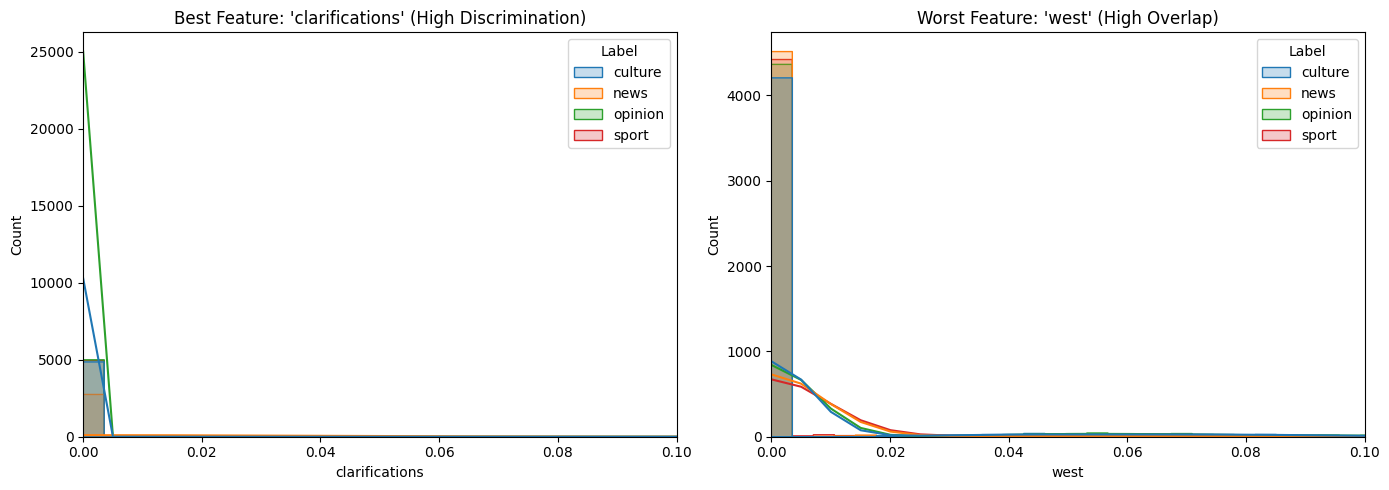

In [35]:
def run_feature_selection(df, k=200):
    
    X = df.drop(columns=['Label'])
    y = df['Label']
    
    # 1. Quantitative: Select K Best
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X, y)
    
    cols_idxs = selector.get_support(indices=True)
    selected_features = X.columns[cols_idxs].tolist()
    
    # Create result DF
    X_selected = X[selected_features]
    final_df = pd.concat([y, X_selected], axis=1)
    
    # Get scores for visualization logic
    scores_df = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
    scores_df = scores_df.sort_values(by='Score', ascending=False)
    
    print(f"Selected top {k} features.")
    print("Top 5 Features:\n", scores_df.head(5))
    
    # 2. Qualitative: Visualization (Best vs Worst)
    best_feat = scores_df.iloc[0]['Feature']
    worst_feat = scores_df.iloc[-1]['Feature']
    
    plt.figure(figsize=(14, 5))
    
    #  ZoomIn 
    ZOOM_LIMIT = 0.1 
    
    # Best Feature
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=best_feat, hue='Label', kde=True, element="step", common_norm=False)
    plt.title(f"Best Feature: '{best_feat}' (High Discrimination)")
    plt.xlim(0, ZOOM_LIMIT)

    # Worst Feature
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=worst_feat, hue='Label', kde=True, element="step", common_norm=False)
    plt.title(f"Worst Feature: '{worst_feat}' (High Overlap)")
    plt.xlim(0, ZOOM_LIMIT) 
    
    plt.tight_layout()
    plt.show()
    
    return final_df

df_selected = run_feature_selection(df_represented, k=200)

Dimensionality_Reduction 


 Starting PCA 
Explained Variance: [0.11121124 0.05031674 0.03999495]
Total Preserved: 20.15%


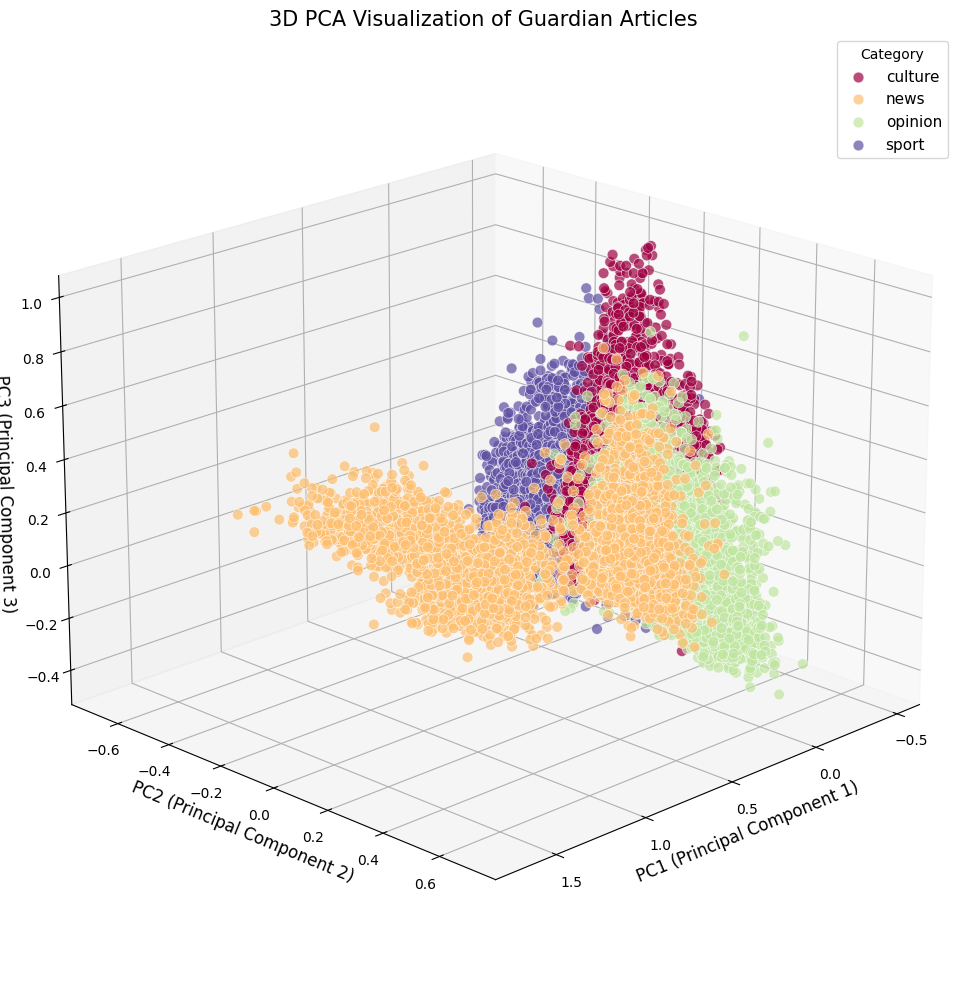


Top 200 Selected Features (Arranged 20x10):


,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10
0,actor,add,administration,album,amend,art,article,artist,artists,arts
1,ball,band,bat,batter,beat,ben,best,bite,bowl,captain
2,career,champion,championship,chance,character,chase,clarifications,click,club,coach
3,colbert,columnist,come,comedy,competition,complaints,consider,corrections,covid,cricket
4,cultural,cup,debut,defeat,democracy,democratic,director,donald,dont,drama
5,economic,economy,editor,email,england,englands,fan,feel,festival,field
6,fifth,film,final,finish,forward,fourth,fun,funny,game,gaza
7,good,government,governments,grand,guardian,head,hes,host,include,injury
8,innings,issue,jimmy,joke,kick,kimmel,kings,know,labour,late
9,laugh,law,lead,league,letter,life,like,lions,live,london


In [36]:

def run_pca_and_visualize(df):
    """
    PCA for 3D Visualization using Modern Matplotlib syntax.
    """
    print("\n Starting PCA ")
    
    feature_cols = [col for col in df.columns if col != 'Label']
    X = df[feature_cols].values
    y = df['Label']

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(le.classes_)

    # PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    print(f"Explained Variance: {pca.explained_variance_ratio_}")
    print(f"Total Preserved: {sum(pca.explained_variance_ratio_):.2%}")
    
    # Create DataFrame for Plotting
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])
    pca_df['Label'] = y.values
    
    # 3D Plot Configuration
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    #  COLOR MAPPING
    cmap = mpl.colormaps['Spectral']
    colors = [cmap(i / (num_classes - 1)) for i in range(num_classes)]
    
    for i, target in enumerate(le.classes_):
        indices = y_encoded == i
        ax.scatter(pca_df.loc[indices, 'PC1'], 
                   pca_df.loc[indices, 'PC2'], 
                   pca_df.loc[indices, 'PC3'], 
                   label=target, 
                   color=colors[i],
                   s=60,           
                   alpha=0.7,       
                   edgecolor='w',  
                   linewidth=0.5)
    
    ax.set_title('3D PCA Visualization of Guardian Articles', fontsize=15)
    ax.set_xlabel('PC1 (Principal Component 1)', fontsize=12)
    ax.set_ylabel('PC2 (Principal Component 2)', fontsize=12)
    ax.set_zlabel('PC3 (Principal Component 3)', fontsize=12)
    ax.legend(title='Category', loc='upper right', fontsize=11)
    
    ax.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    return pca_df

# Run the step
df_pca = run_pca_and_visualize(df_selected)

# Display Selected Features (20x10 Grid)
selected_feats = [col for col in df_selected.columns if col != 'Label']
num_to_display = 200
top_feats = selected_feats[:num_to_display]

# Pad with empty strings if fewer than 200 features exist
if len(top_feats) < num_to_display:
    top_feats += [''] * (num_to_display - len(top_feats))

# Reshape list into a 20x10 matrix
reshaped_feats = np.array(top_feats).reshape(20, 10)

# Create DataFrame for formatted output
features_matrix = pd.DataFrame(reshaped_feats, columns=[f'Group {i+1}' for i in range(10)])

print("\n" + "="*60)
print(f"Top {num_to_display} Selected Features (Arranged 20x10):")
print("="*60)

features_matrix